In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

In [2]:
def generate_data(n_samples: int, mean_0: float = 1., mean_1: float = 5.):
    data = []
    for _ in range(n_samples):
        if np.random.uniform() < 0.4:
            data.append(np.random.normal(mean_0, 0.5))
        else:
            data.append(np.random.normal(mean_1, 0.5))
    return data

In [3]:
n_samples = 1000
data = generate_data(n_samples)

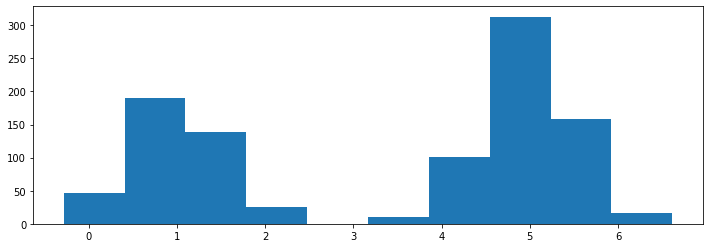

In [4]:
plt.subplots(figsize=(12, 4))
plt.hist(data);

We have data $D = \{x_{1}, ..., x_{1000}\}$ <br><br>
There is some generating process $x_{i} \sim p(x)$ <br><br>
We want to approximate it $q(x, \theta)$.

Let's use maximum likelihood estimation: <br><br>
$L(\theta) = \prod_{i=1}^{1000}q(x_{i}, \theta)$<br><br>

Or in terms of loss (and log): <br><br>
$loss(\theta) = -\sum_{i=1}^{1000}log(q(x_{i}, \theta))$<br><br>

This concept is connect to Kullback-Leibler divergence. Let's define empirical distribution $p_{data}$. <br><br>
$p_{data}(x) = \frac{1}{1000}\sum_{i=1}^{1000}I(x = x_{i})$

Basically we want to find such q that minimizes $KL(p_{data}, q)$.

$KL(p_{data}, q) = E_{p_{data}}[log(\frac{p_{data}}{q})] = \sum_{x_{i}}p_{data}(x_{i})log(\frac{p_{data}(x_{i})}{q(x_{i}, \theta)}) = -\sum_{x_{i}}p_{data}(x_{i})log(q(x_{i}, \theta))$ <br><br>

In the last equality sign we ignored the terms that don't depend on $\theta$. The summing is over distinct $x_{i}$ and it can be easily see that the both formulations are equivalent.

In [5]:
p_data = tfd.Mixture(
    cat=tfd.Categorical(probs=np.ones(n_samples) / n_samples),
    components=[
        tfd.Deterministic(loc=x_i)
        for x_i in data
    ]
)

In [6]:
p_data

<tfp.distributions.Mixture 'Mixture' batch_shape=[] event_shape=[] dtype=float32>

In [7]:
p_data.sample()

<tf.Tensor: shape=(), dtype=float32, numpy=5.5257807>

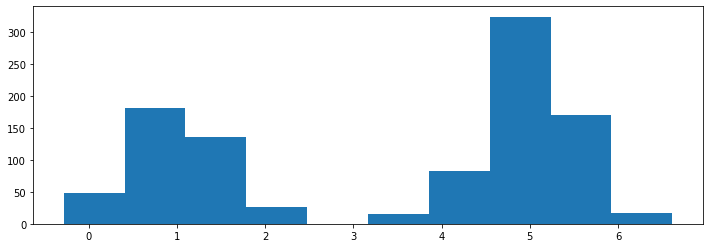

In [8]:
plt.subplots(figsize=(12, 4))
plt.hist(p_data.sample(1000).numpy());

It looks like gaussian mixture, let's find a bimodal distribution, whose distance from empirical one will be minimized.

In [9]:
q = tfd.Mixture(
    cat=tfd.Categorical(tf.Variable([0.5, 0.5], name='proportion')),
    components=[
        tfd.Normal(
            loc=tf.Variable(0.5, name='loc_1'),
            scale=tf.Variable(0.5, name='scale_1')
        ),
        tfd.Normal(
            loc=tf.Variable(4.5, name='loc_2'),
            scale=tf.Variable(0.5, name='scale_2')
        )
    ]
)

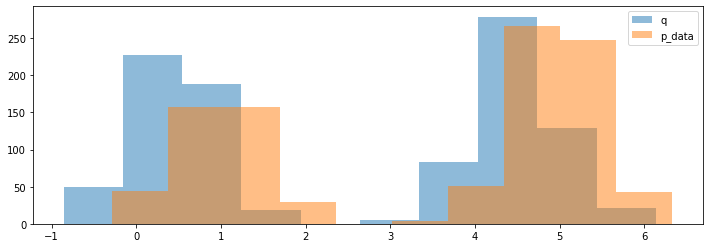

In [10]:
plt.subplots(figsize=(12, 4))
plt.hist(q.sample(1000).numpy(), alpha=0.5, label='q')
plt.hist(p_data.sample(1000).numpy(), alpha=0.5, label='p_data')
plt.legend();

In [11]:
# you need to write code by yourself, because there is no analytical solution in the tfp library 

tfd.kl_divergence(p_data, q)

NotImplementedError: No KL(distribution_a || distribution_b) registered for distribution_a type Mixture and distribution_b type Mixture

In [12]:
n_steps = 50
batch_size = 300
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

loss_history = []

for i in range(n_steps):
    sample = p_data.sample(batch_size)

    with tf.GradientTape() as tape:
        
        loss = -tf.reduce_mean(q.log_prob(sample))
    
    grads = tape.gradient(loss, q.trainable_variables)
    optimizer.apply_gradients(zip(grads, q.trainable_variables))
    
    
    #if i % 20:
    print(f'loss after step: {i + 1} = {loss}')
    loss_history.append(loss.numpy())

loss after step: 1 = 1.912766695022583
loss after step: 2 = 1.8465700149536133
loss after step: 3 = 1.7979650497436523
loss after step: 4 = 1.7639074325561523
loss after step: 5 = 1.7678234577178955
loss after step: 6 = 1.6863621473312378
loss after step: 7 = 1.679490566253662
loss after step: 8 = 1.7379040718078613
loss after step: 9 = 1.6211357116699219
loss after step: 10 = 1.6803383827209473
loss after step: 11 = 1.6097594499588013
loss after step: 12 = 1.5587395429611206
loss after step: 13 = 1.6207404136657715
loss after step: 14 = 1.6353974342346191
loss after step: 15 = 1.5616978406906128
loss after step: 16 = 1.5589146614074707
loss after step: 17 = 1.5718300342559814
loss after step: 18 = 1.5779242515563965
loss after step: 19 = 1.61593496799469
loss after step: 20 = 1.5183606147766113
loss after step: 21 = 1.5526570081710815
loss after step: 22 = 1.5483267307281494
loss after step: 23 = 1.4995334148406982
loss after step: 24 = 1.5342929363250732
loss after step: 25 = 1.50901

In [13]:
def moving_average(x):
    return np.cumsum(x) / np.arange(1, len(x) + 1)

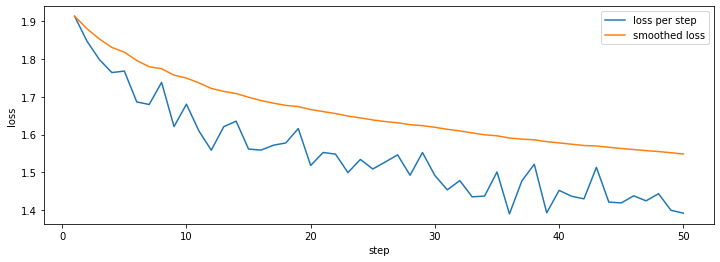

In [14]:
plt.subplots(figsize=(12, 4))
plt.plot(np.arange(1, n_steps + 1), loss_history, label='loss per step')
plt.plot(np.arange(1, n_steps + 1), moving_average(loss_history), label='smoothed loss')
plt.xlabel('step')
plt.ylabel('loss')
plt.legend();

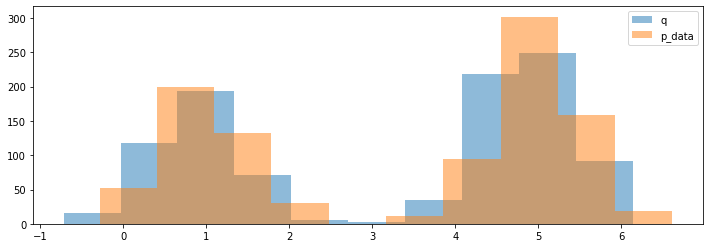

In [15]:
plt.subplots(figsize=(12, 4))
plt.hist(q.sample(1000).numpy(), alpha=0.5, label='q')
plt.hist(p_data.sample(1000).numpy(), alpha=0.5, label='p_data')
plt.legend();

In [16]:
q.variables

(<tf.Variable 'proportion:0' shape=(2,) dtype=float32, numpy=array([0.28932348, 0.71067667], dtype=float32)>,
 <tf.Variable 'loc_1:0' shape=() dtype=float32, numpy=0.8905964>,
 <tf.Variable 'scale_1:0' shape=() dtype=float32, numpy=0.52047616>,
 <tf.Variable 'loc_2:0' shape=() dtype=float32, numpy=4.8718786>,
 <tf.Variable 'scale_2:0' shape=() dtype=float32, numpy=0.5298672>)